# Project 1

Mama mia, here we go again with classification...

## Imports 

In [35]:
import sys

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns

print(f"Python version: {sys.version}.")

Python version: 3.10.4 (main, Mar 31 2022, 03:38:35) [Clang 12.0.0 ].


## Loading Data

In [12]:
df_train = pd.read_csv("./Data_train.csv")

In [13]:
df_train.head()

,Unnamed: 0,x,y,class
0,0,9.478938,-4.950071,1
1,1,-8.476344,3.635107,3
2,2,4.080771,-3.684994,3
3,3,-0.509729,-5.700655,2
4,4,-0.898476,-4.007790,3


In [14]:
df_train = df_train.drop("Unnamed: 0", axis='columns')
df_train.head()

,x,y,class
0,9.478938,-4.950071,1
1,-8.476344,3.635107,3
2,4.080771,-3.684994,3
3,-0.509729,-5.700655,2
4,-0.898476,-4.007790,3


In [16]:
X_train, y_train = df_train[["x", "y"]], df_train["class"].values.reshape(-1, 1)

Let's do the same for the test data:

In [17]:
df_test = pd.read_csv("./Data_test.csv").drop("Unnamed: 0", axis='columns')
df_test.head()

,x,y,class
0,2.597513,-1.720239,1
1,7.951270,6.252087,2
2,-6.913355,4.858647,3
3,-2.948122,-0.585784,3
4,0.865727,-3.874243,3


In [18]:
X_test, y_test = df_test[["x", "y"]], df_test["class"].values.reshape(-1, 1)

## Task 0: Naive Logistic Regression

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

Let's scale our data to be Gaussian:

In [26]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

And let's also do a quick visualization to verify we have nonlinear data:

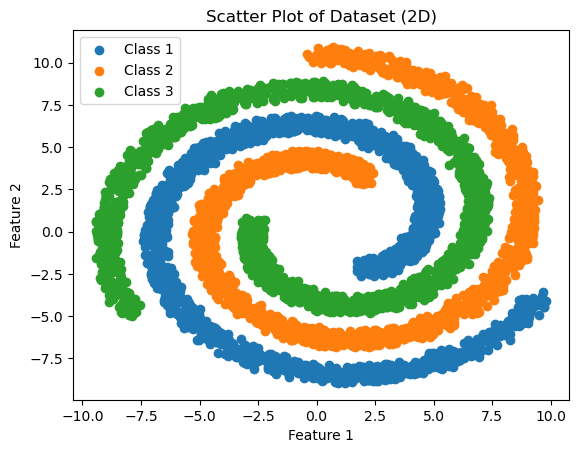

In [58]:
class1, class2, class3 = (
    df_train[df_train["class"] == 1][["x", "y"]],
    df_train[df_train["class"] == 2][["x", "y"]],
    df_train[df_train["class"] == 3][["x", "y"]],
)

plt.scatter(class1["x"], class1["y"], label='Class 1')
plt.scatter(class2["x"], class2["y"], label='Class 2')
plt.scatter(class3["x"], class3["y"], label='Class 3')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Scatter Plot of Dataset (2D)")
plt.legend()
plt.show()

Intriguing!
Okay, so by this plot we need to make sure our model can handle multinomial problems. The args I'm passing below are the defaults, but I just to be explicit about the type of model being created (and further description can be found on the `sklearn` [docs](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)).

In [59]:
model = LogisticRegression(solver='lbfgs', multi_class='multinomial')
model.fit(X_train, np.squeeze(y_train))

LogisticRegression(multi_class='multinomial')

In [60]:
accuracy = model.score(X_test, y_test)
print(f"Naive Logisitic Regression Accuracy: {round(accuracy * 100, 4)}%.")

Naive Logisitic Regression Accuracy: 34.7733%.


Accuracy is only ~34% (not great). Can we see a visualization of this model as well?

/Applications/anaconda3/envs/559/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


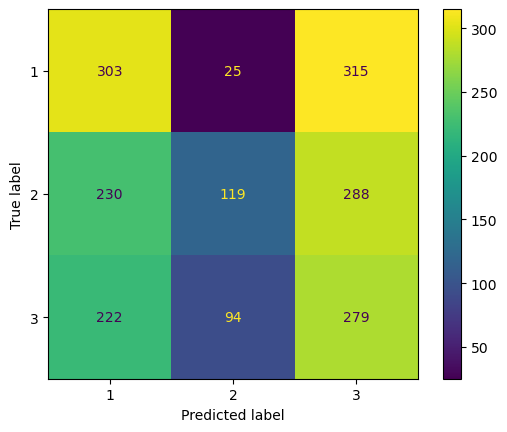

In [63]:
ConfusionMatrixDisplay.from_estimator(model, X_test_scaled, y_test)
plt.show()

## Task 1: Train Data Transformation

### Natural Log

Maybe we can make the dataset linear using the natural log?

In [67]:
df_train_transformed = df_train.copy()
df_train["ln_y"] = np.log(df_train["x"].values)

/var/folders/n0/3kqw7k395kb6swksbngs7zw40000gn/T/ipykernel_14474/855529085.py:2: RuntimeWarning: invalid value encountered in log
  df_train["ln_y"] = np.log(df_train["x"].values)


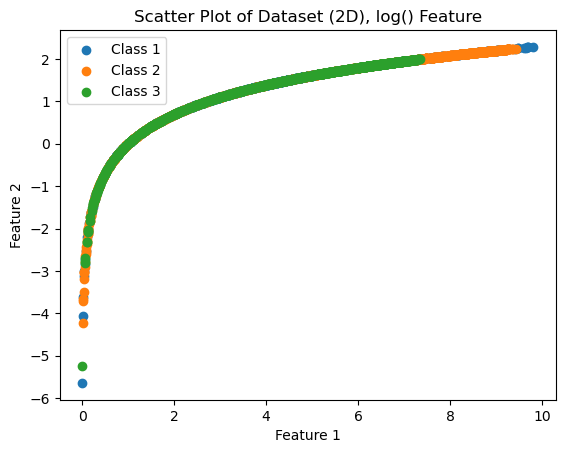

In [104]:
class1, class2, class3 = (
    df_train_transformed[df_train["class"] == 1][["x", "ln_y"]],
    df_train_transformed[df_train["class"] == 2][["x", "ln_y"]],
    df_train_transformed[df_train["class"] == 3][["x", "ln_y"]],
)

plt.scatter(class1["x"], class1["ln_y"], label='Class 1')
plt.scatter(class2["x"], class2["ln_y"], label='Class 2')
plt.scatter(class3["x"], class3["ln_y"], label='Class 3')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Scatter Plot of Dataset (2D), log() Feature")
plt.legend()
plt.show()

### Quadratic

Nope? Hmm, what about using a quadratic feature?

In [69]:
def quadratic_feature_mapping(x, y):
    X = np.c_[(x, y)]				
    if len(x) >	2:
        x_1 = X[:,0] ** 2
        x_2 = np.sqrt(2) * X[:,0] * X[:,1]
        x_3 = X[:,1] ** 2								
    else:
        x_1 = X[0] ** 2
        x_2 = np.sqrt(2) * X[0] * X[1]
        x_3 = X[1] ** 2			    
    trans_x = np.array([x_1, x_2, x_3])				
    return trans_x

In [72]:
quadratic_X_train = quadratic_feature_mapping(
    np.squeeze(X_train["x"].values),
    np.squeeze(X_train["y"].values),
).T

In [73]:
quadratic_X_train.shape

(5625, 3)

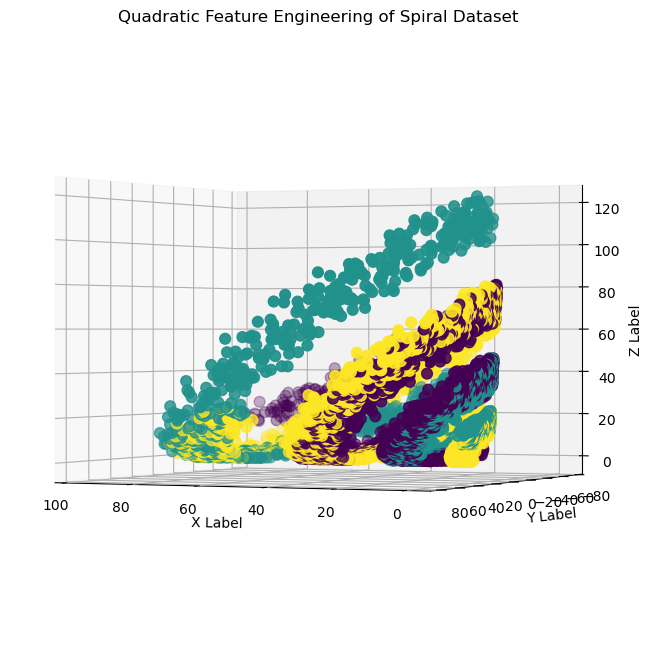

In [103]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(quadratic_X_train[:, 0],
           quadratic_X_train[:, 1],
           quadratic_X_train[:, 2],
           c=np.squeeze(df_train["class"].values), s=60)
ax.view_init(0, 115)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.title("Quadratic Feature Engineering of Spiral Dataset")
plt.show()

### RBF

The quadratic mapping didn't seem to do much better. How about RBF?

I will be using the formulation of RBF kernel provided from [[1]](https://www.youtube.com/watch?v=Q0ExqOphnW0), found on YouTube.

In [83]:
def rbf_feature_mapping(x, y):
    rbf_feat = (
        -0.5 * (np.linalg(x - y) ** 2)
    )   
    trans_x = np.array([x, y, rbf_feat])				
    return trans_x

In [98]:
rbf_X_train = quadratic_feature_mapping(
    np.squeeze(X_train["x"].values),
    np.squeeze(X_train["y"].values),
)

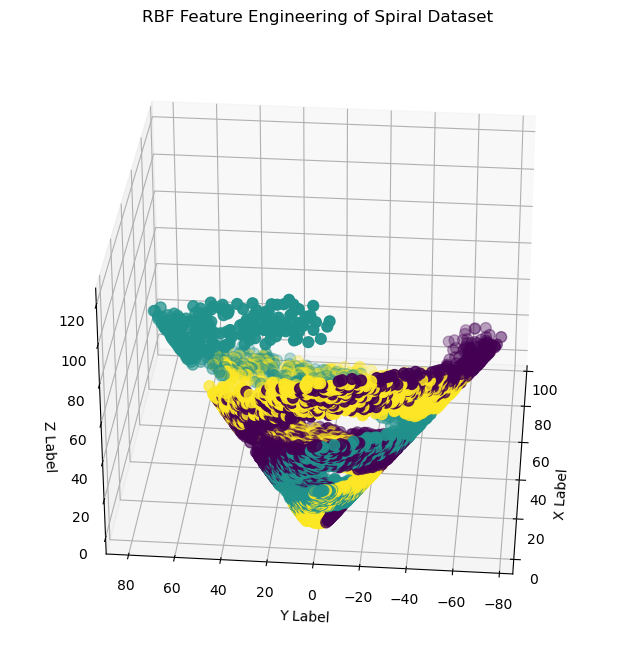

In [102]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rbf_X_train[0, :],
           rbf_X_train[1, :],
           rbf_X_train[2, :],
           c=np.squeeze(df_train["class"].values), s=60)
ax.view_init(30, 185)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.title("RBF Feature Engineering of Spiral Dataset")
plt.show()